In [1]:
import sqlite3
import pandas as pd
import filterbyip as fbi
import clusterbycolumn as cbc
import requests
import asinfo

import matplotlib.dates as dates
from datetime import datetime as dt

In [2]:
import warnings
warnings.filterwarnings('ignore')

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
from IPython.core.display import HTML
css = open('style-table.css').read() + open('style-notebook.css').read()
HTML('<style>{}</style>'.format(css))

In [4]:
def asn_from_probe_name(probe_name):
    base = 'http://leone-collector.eecs.jacobs-university.de/msmpoint'
    msm_metadata = requests.get('%s/%s'%(base, probe_name))
    asn4 = str(msm_metadata.json()['asn4'])
    asn6 = str(msm_metadata.json()['asn6'])
    return asn4,asn6

In [5]:
dailydb_location = '/data/vbajpai/datasets/youtube-data-collection-python3/youtube.db'

In [6]:
query = '''select   msmpoint.name as probe
                  , dtime
                  , video_address
                  , video_download_bytes_sec
                  , audio_download_bytes_sec
           from youtube, msmpoint
           where youtube.unit_id = msmpoint.skunitid
           and msmpoint.skunitid <> ''
           and successes = 1
           and failures = 0;
        '''

In [7]:
con = sqlite3.connect(dailydb_location)
df = pd.read_sql(query, con)

In [8]:
df.count()

probe                       4422465
dtime                       4422465
video_address               4422465
video_download_bytes_sec    4422465
audio_download_bytes_sec    4422465
dtype: int64

In [9]:
df.head()

,probe,dtime,video_address,video_download_bytes_sec,audio_download_bytes_sec
0,samsbox81,2016-09-05 16:29:41,193.212.4.15,2006335,1242187
1,samsbox81,2016-09-05 16:30:23,2001:4600:9:307::f,2032809,1146949
2,samsbox81,2016-09-05 17:26:17,193.212.4.15,1946785,1214358
3,samsbox81,2016-09-05 17:26:59,2001:4600:9:307::f,2008980,889966
4,samsbox81,2016-09-05 18:25:53,193.212.4.15,1927047,1181569


In [10]:
def round_time_to_nearest_hour(dtime):
    import datetime;    
    d = datetime.datetime.strptime(dtime, "%Y-%m-%d %H:%M:%S")
    d = d.replace(minute=0, second=0)
    dtime = d.strftime('%Y-%m-%d %H:%M:%S')
    return dtime

In [11]:
df['dtime'] = df['dtime'].apply(round_time_to_nearest_hour)

In [14]:
df = df.sort_values('dtime')

In [15]:
df.head()

,probe,dtime,video_address,video_download_bytes_sec,audio_download_bytes_sec
3036654,samsbox24,2014-08-20 01:00:00,173.194.137.147,457484,81165
3036655,samsbox24,2014-08-20 04:00:00,173.194.137.147,456881,83834
3036656,samsbox24,2014-08-20 06:00:00,173.194.137.147,454969,83514
3036657,samsbox24,2014-08-20 08:00:00,173.194.137.147,456777,83162
3036658,samsbox24,2014-08-20 09:00:00,173.194.137.147,459497,83982


In [16]:
df.tail()

,probe,dtime,video_address,video_download_bytes_sec,audio_download_bytes_sec
1490979,samsbox63,2017-06-27 23:00:00,2607:f8b0:400b:f::8,938389,627823
516635,samsbox45,2017-06-27 23:00:00,173.194.20.202,810563,535373
1490978,samsbox63,2017-06-27 23:00:00,74.216.233.205,942901,568052
961953,samsbox30,2017-06-27 23:00:00,173.194.11.170,812448,559443
4422464,samsbox91,2017-06-27 23:00:00,62.231.78.13,1019577,1266532


In [17]:
num_probes = len(set(df['probe']))

In [18]:
df.count()

probe                       4422465
dtime                       4422465
video_address               4422465
video_download_bytes_sec    4422465
audio_download_bytes_sec    4422465
dtype: int64

In [19]:
df = df.dropna()

In [20]:
df.count()

probe                       4422465
dtime                       4422465
video_address               4422465
video_download_bytes_sec    4422465
audio_download_bytes_sec    4422465
dtype: int64

In [21]:
df['v_MB_sec'] = df['video_download_bytes_sec'].div(1024).div(1024)
df['a_MB_sec'] = df['audio_download_bytes_sec'].div(1024).div(1024)

del df['video_download_bytes_sec']
del df['audio_download_bytes_sec']

In [22]:
def filter_by_ip(df, column):
  """reads a DataFrame, calls fbi.filter_v{4,6} to get DataFrames with rows
     containing only v4, v6 endpoints. Returns the two DataFrame as a tuple"""

  dfv6 = fbi.filter_v6(df, column)
  dfv4 = fbi.filter_v4(df, column)
  return dfv4, dfv6

In [23]:
dfv4, dfv6 = filter_by_ip(df, column = 'video_address')

In [24]:
dfv4['name'] = dfv4['probe'].apply(lambda name: "#%02d"%int(name[7:]))
dfv6['name'] = dfv6['probe'].apply(lambda name: "#%02d"%int(name[7:]))
del dfv4['probe']; del dfv6['probe']

In [25]:
dfv4.head()

,dtime,video_address,v_MB_sec,a_MB_sec,name
3036654,2014-08-20 01:00:00,173.194.137.147,0.436291,0.077405,#24
3036655,2014-08-20 04:00:00,173.194.137.147,0.435716,0.079950,#24
3036656,2014-08-20 06:00:00,173.194.137.147,0.433892,0.079645,#24
3036657,2014-08-20 08:00:00,173.194.137.147,0.435616,0.079309,#24
3036658,2014-08-20 09:00:00,173.194.137.147,0.438210,0.080091,#24


In [26]:
dfv6.head()

,dtime,video_address,v_MB_sec,a_MB_sec,name
1053420,2014-08-21 13:00:00,2a00:1450:4009:36::e,0.017399,0.018577,#10
1775431,2014-08-21 13:00:00,2a00:1450:4009:36::e,0.018060,0.022757,#07
1775433,2014-08-21 14:00:00,2a00:1450:4009:36::e,0.023813,0.022521,#07
2196472,2014-08-21 14:00:00,2a02:c7a:8000:306::e,0.915850,0.058596,#05
1053422,2014-08-21 14:00:00,2a00:1450:4009:36::e,0.018871,0.017064,#10


The history saving thread hit an unexpected error (OperationalError('database is locked',)).History will not be written to the database.


In [27]:
df = pd.merge(dfv4, dfv6, on=["name", "dtime"])

In [28]:
df.count()

dtime              6581885
video_address_x    6581885
v_MB_sec_x         6581885
a_MB_sec_x         6581885
name               6581885
video_address_y    6581885
v_MB_sec_y         6581885
a_MB_sec_y         6581885
dtype: int64

In [29]:
df.head()

,dtime,video_address_x,v_MB_sec_x,a_MB_sec_x,name,video_address_y,v_MB_sec_y,a_MB_sec_y
0,2014-08-21 13:00:00,173.194.13.78,0.899893,0.058582,#07,2a00:1450:4009:36::e,0.018060,0.022757
1,2014-08-21 13:00:00,173.194.3.78,0.995450,0.058147,#10,2a00:1450:4009:36::e,0.017399,0.018577
2,2014-08-21 14:00:00,2.127.252.206,0.923759,0.058353,#05,2a02:c7a:8000:306::e,0.915850,0.058596
3,2014-08-21 14:00:00,173.194.13.78,0.901196,0.058470,#07,2a00:1450:4009:36::e,0.023813,0.022521
4,2014-08-21 14:00:00,173.194.3.78,0.984295,0.057911,#10,2a00:1450:4009:36::e,0.018871,0.017064


In [30]:
df.rename(columns={  'video_address_x'      : 'video_ep_v4'
                   , 'v_MB_sec_x'           : 'v_MB_sec_v4'
                   , 'a_MB_sec_x'           : 'a_MB_sec_v4'                   
                   , 'video_address_y'      : 'video_ep_v6'
                   , 'v_MB_sec_y'           : 'v_MB_sec_v6'
                   , 'a_MB_sec_y'           : 'a_MB_sec_v6'                                      
                  } ,  inplace=True)

In [31]:
del df['video_ep_v4']; del df['video_ep_v6']

In [32]:
df.head()

,dtime,v_MB_sec_v4,a_MB_sec_v4,name,v_MB_sec_v6,a_MB_sec_v6
0,2014-08-21 13:00:00,0.899893,0.058582,#07,0.018060,0.022757
1,2014-08-21 13:00:00,0.995450,0.058147,#10,0.017399,0.018577
2,2014-08-21 14:00:00,0.923759,0.058353,#05,0.915850,0.058596
3,2014-08-21 14:00:00,0.901196,0.058470,#07,0.023813,0.022521
4,2014-08-21 14:00:00,0.984295,0.057911,#10,0.018871,0.017064


In [33]:
df.tail()

,dtime,v_MB_sec_v4,a_MB_sec_v4,name,v_MB_sec_v6,a_MB_sec_v6
6581880,2017-06-27 23:00:00,0.934583,0.560267,#85,0.946038,0.565170
6581881,2017-06-27 23:00:00,0.742577,0.374588,#17,0.722433,0.318105
6581882,2017-06-27 23:00:00,0.763723,0.541965,#14,0.761852,0.522307
6581883,2017-06-27 23:00:00,0.899220,0.541737,#63,0.894917,0.598739
6581884,2017-06-27 23:00:00,0.774811,0.533526,#30,0.765129,0.470574


In [34]:
df.count()

dtime          6581885
v_MB_sec_v4    6581885
a_MB_sec_v4    6581885
name           6581885
v_MB_sec_v6    6581885
a_MB_sec_v6    6581885
dtype: int64

In [35]:
df['v4v6_v_MB_sec'] = df.v_MB_sec_v4.map(str) + ',' + df.v_MB_sec_v6.map(str)
df['v4v6_a_MB_sec'] = df.a_MB_sec_v4.map(str) + ',' + df.a_MB_sec_v6.map(str)

In [36]:
df.count()

dtime            6581885
v_MB_sec_v4      6581885
a_MB_sec_v4      6581885
name             6581885
v_MB_sec_v6      6581885
a_MB_sec_v6      6581885
v4v6_v_MB_sec    6581885
v4v6_a_MB_sec    6581885
dtype: int64

### Calculate Absolute Difference

In [37]:
def get_difference(v4v6_throughput):
    
    v4, v6 = v4v6_throughput.split(',')
    try: v4 = float(v4); v6 = float(v6)
    except Exception as e: print(e, v4v6_throughput)
    
    difference = (v6 - v4) 
    return float('%0.2f'%difference)

df['v_MB_sec_a'] = df['v4v6_v_MB_sec'].apply(get_difference)
df['a_MB_sec_a'] = df['v4v6_a_MB_sec'].apply(get_difference)

### Calculate Relative Difference

In [38]:
def get_slowness(v4v6_throughput):
    
    v4, v6 = v4v6_throughput.split(',')
    try: v4 = float(v4); v6 = float(v6)
    except Exception as e: print(e, v4v6_throughput)
    
    try: slowness = (v6 - v4) / v4
    except Exception as e: return 0
    return float('%0.2f'%slowness)

df['v_MB_sec_r'] = df['v4v6_v_MB_sec'].apply(get_slowness)
df['a_MB_sec_r'] = df['v4v6_a_MB_sec'].apply(get_slowness)

In [39]:
del df['v4v6_a_MB_sec']; del df['v4v6_v_MB_sec']

In [40]:
df.head()

,dtime,v_MB_sec_v4,a_MB_sec_v4,name,v_MB_sec_v6,a_MB_sec_v6,v_MB_sec_a,a_MB_sec_a,v_MB_sec_r,a_MB_sec_r
0,2014-08-21 13:00:00,0.899893,0.058582,#07,0.018060,0.022757,-0.88,-0.04,-0.98,-0.61
1,2014-08-21 13:00:00,0.995450,0.058147,#10,0.017399,0.018577,-0.98,-0.04,-0.98,-0.68
2,2014-08-21 14:00:00,0.923759,0.058353,#05,0.915850,0.058596,-0.01,0.00,-0.01,0.00
3,2014-08-21 14:00:00,0.901196,0.058470,#07,0.023813,0.022521,-0.88,-0.04,-0.97,-0.61
4,2014-08-21 14:00:00,0.984295,0.057911,#10,0.018871,0.017064,-0.97,-0.04,-0.98,-0.71


In [41]:
df.count()

dtime          6581885
v_MB_sec_v4    6581885
a_MB_sec_v4    6581885
name           6581885
v_MB_sec_v6    6581885
a_MB_sec_v6    6581885
v_MB_sec_a     6581885
a_MB_sec_a     6581885
v_MB_sec_r     6581885
a_MB_sec_r     6581885
dtype: int64

In [42]:
import Cdf
import Pmf

sample = df['v_MB_sec_a'].values
c_v      = Cdf.MakeCdfFromList(sample)
cc_v     = [1 - p for x, p in c_v.Items()]

sample = df['a_MB_sec_a'].values
c_a      = Cdf.MakeCdfFromList(sample)
cc_a     = [1 - p for x, p in c_a.Items()]

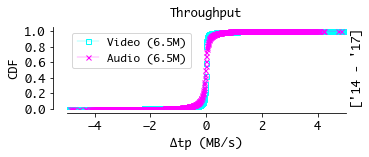

In [50]:
fig = plt.figure(figsize = (5,1.5))
plt.rcParams['font.size'] = 12
ax = plt.gca()
yticks = np.arange(0,1.1,0.2)

plt.plot(c_v.xs, c_v.ps, marker='s', linewidth=0.3, markersize=5, fillstyle='none', color = 'Cyan')
plt.plot(c_a.xs, c_a.ps, marker='x', linewidth=0.3, markersize=5, fillstyle='none', color = 'Magenta')

ax = fig.axes[0]
ax.grid(False)
ax.set_yticks(yticks)
ax.set_ylim([0,1.05])
ax.set_xlim([-5,5])
ax.set_xscale('linear')
ax.set_xlabel('∆tp (MB/s)', fontsize=12)
ax.set_ylabel('CDF', fontsize=12)

plt.legend(["Video (6.5M)", "Audio (6.5M)"], fontsize=11, loc='upper left')

ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
ax.spines['bottom'].set_position(('axes', -0.05))
ax.spines['left'].set_position(('axes', -0.05))

ax3 = ax.twinx()
ax3.spines['right'].set_color('none')
ax3.spines['top'].set_color('none')
ax3.spines['left'].set_color('none')
ax3.spines['bottom'].set_color('none')
ax3.yaxis.set_ticks_position('none')
ax3.set_ylabel('[\'14 - \'17]')
plt.setp(ax3.get_yticklabels(), visible=False)

plt.title('Throughput', fontsize=12, y=1.05)
plt.savefig('yt-throughput-difference.pdf', format='pdf', bbox_inches='tight')

### CDF of absolute difference of throughput between IPv4 and IPv6 over the entire duration. 20% of the video samples achieve higher throughput over IPv6 with 5% of them being achieving more than 1MB/s higher throughput. On the contrary, 9% achieve lower than 1MB/s throughput over IPv6. Similarly 35% of the audio samples achieve higher throughput over IPv6 with 4% of them achieving more than 1MB/s higher throughput. On the contrary, 7% achieve lower than 1MB/s throughput over IPv6. 

In [44]:
with open('throughput-video.csv', 'w') as f: 
    f.write('values; percentile\n')
    for x, y in zip(c_v.xs, c_v.ps): f.write('%.2f; %.2f\n'%(x,y))
        
with open('throughput-audio.csv', 'w') as f: 
    f.write('values; percentile\n')
    for x, y in zip(c_a.xs, c_a.ps): f.write('%.2f; %.2f\n'%(x,y))        